In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance

from lightgbm import LGBMClassifier, plot_importance
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
import lightgbm
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import time

In [7]:
def get_clf_eval(Y_test, pred, pred_proba=None):
    confusion = confusion_matrix(Y_test, pred)
    acc = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    roc_auc = roc_auc_score(Y_test, pred_proba)
    print('Confusion matrix')
    print(confusion)
    print('acc: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}, roc_auc: {:.4f}'.format(acc, precision, recall, f1, roc_auc))
    # print(f'acc: {acc:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, F1: {f1:.4f}')

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
        columns=['dup_cnt'])
    feature_dup_df.reset_index(inplace=True)
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)

    Y_train = pd.read_csv('./human_activity/train/Y_train.txt', sep='\s+', header=None, names=['action'])
    Y_test = pd.read_csv('./human_activity/test/Y_test.txt', sep='\s+', header=None, names=['action'])
    return X_train, X_test, Y_train, Y_test


In [6]:
X_train, X_test, Y_train, Y_test = get_human_dataset()

In [8]:
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(Y_test, pred))

C:\Users\test\AppData\Local\Temp\ipykernel_4784\595365637.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, Y_train)


0.9195792331184255


In [15]:
%%time
params = {
    'max_depth':[8, 16, 24],
    'min_samples_split': [1, 6, 12],
    'min_samples_leaf': [2, 8, 16]
}
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, Y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)

c:\Users\test\.conda\envs\HRD\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\test\.conda\envs\HRD\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\test\.conda\envs\HRD\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\test\.conda\envs\HRD\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    self.retrieve()
  File "c:\Users\test\.conda\envs\HRD\lib\site-packages

{'max_depth': 16, 'min_samples_leaf': 8, 'min_samples_split': 6}
0.9178454842219804
CPU times: total: 9.02 s
Wall time: 25.2 s


In [17]:
%%time
params = {
    'max_depth':[8, 16, 24],
    'min_samples_split': [1, 6, 12],
    'min_samples_leaf': [2, 8, 16]
}
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1, min_samples_leaf=8, max_depth=16, min_samples_split=6)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(Y_test, pred))

<timed exec>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9222938581608415
CPU times: total: 7.98 s
Wall time: 1.79 s


In [18]:
%%time
params = {
    'max_depth':[8, 16, 24],
    'min_samples_split': [1, 6, 12],
    'min_samples_leaf': [2, 8, 16]
}
rf_clf = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1, min_samples_leaf=8, max_depth=16, min_samples_split=6)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(Y_test, pred))

<timed exec>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9189005768578216
CPU times: total: 23.9 s
Wall time: 4.57 s


In [19]:
%%time
params = {
    'max_depth':[8, 16, 24],
    'min_samples_split': [1, 6, 12],
    'min_samples_leaf': [2, 8, 16]
}
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, min_samples_leaf=8, max_depth=16, min_samples_split=6)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(Y_test, pred))

<timed exec>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9222938581608415
CPU times: total: 1min 22s
Wall time: 15.5 s


In [27]:
top20 = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]

<AxesSubplot:>

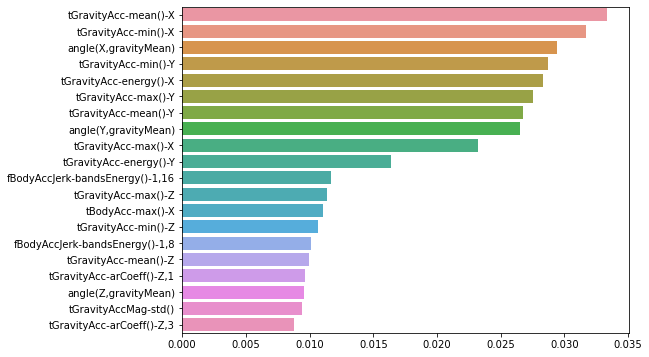

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top20, y=top20.index)

In [35]:
%%time
X_train, X_test, Y_train, Y_test = get_human_dataset()
start = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, Y_train)
pred = gb_clf.predict(X_test)
print(accuracy_score(Y_test, pred))



end = time.time()
print(end - start)

c:\Users\test\.conda\envs\HRD\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9389209365456397
589.0330054759979
CPU times: total: 9min 49s
Wall time: 9min 52s


In [2]:
##########################################################

In [6]:
dataset = load_breast_cancer()
cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=156)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=156)

In [16]:
dtr = xgb.DMatrix(data=X_tr, label=Y_tr)
dval = xgb.DMatrix(data=X_val, label=Y_val)
dtest = xgb.DMatrix(data=X_test, label=Y_test)

In [17]:
params = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 400

In [18]:
eval_list = [
    (dtr, 'train'),
    (dval, 'eval')
]
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_round, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.46675	eval-logloss:0.53228
[1]	train-logloss:0.33646	eval-logloss:0.45357
[2]	train-logloss:0.24920	eval-logloss:0.39144
[3]	train-logloss:0.19143	eval-logloss:0.34799
[4]	train-logloss:0.15009	eval-logloss:0.31363
[5]	train-logloss:0.11959	eval-logloss:0.29787
[6]	train-logloss:0.09783	eval-logloss:0.28493
[7]	train-logloss:0.08144	eval-logloss:0.27381
[8]	train-logloss:0.06913	eval-logloss:0.26692
[9]	train-logloss:0.05994	eval-logloss:0.26585
[10]	train-logloss:0.05284	eval-logloss:0.26670
[11]	train-logloss:0.04622	eval-logloss:0.26861
[12]	train-logloss:0.04081	eval-logloss:0.26767
[13]	train-logloss:0.03590	eval-logloss:0.27313
[14]	train-logloss:0.03233	eval-logloss:0.28080
[15]	train-logloss:0.02958	eval-logloss:0.27402
[16]	train-logloss:0.02692	eval-logloss:0.27108
[17]	train-logloss:0.02475	eval-logloss:0.27472
[18]	train-logloss:0.02259	eval-logloss:0.27689
[19]	train-logloss:0.02081	eval-logloss:0.28267
[20]	train-logloss:0.01928	eval-logloss:0.27917
[2

In [20]:
pred_probs = xgb_model.predict(dtest)
np.round(pred_probs, 3)


array([0.983, 0.006, 0.615, 0.047, 0.994, 1.   , 1.   , 1.   , 0.999,
       0.   , 0.   , 0.   , 1.   , 1.   , 0.999, 0.998, 0.997, 1.   ,
       1.   , 0.999, 0.   , 0.147, 0.   , 1.   , 0.   , 0.897, 0.001,
       0.   , 0.999, 0.135, 0.987, 0.   , 0.983, 0.938, 0.002, 0.   ,
       0.997, 1.   , 0.143, 0.999, 0.378, 0.999, 0.999, 1.   , 0.999,
       0.863, 0.015, 1.   , 0.999, 1.   , 0.999, 0.001, 1.   , 1.   ,
       1.   , 0.999, 1.   , 0.996, 1.   , 0.895, 0.999, 0.933, 0.   ,
       0.001, 1.   , 0.997, 0.001, 0.993, 1.   , 1.   , 0.   , 0.999,
       0.   , 0.999, 0.999, 0.   , 1.   , 1.   , 1.   , 0.   , 0.   ,
       0.963, 0.999, 1.   , 0.999, 0.992, 0.999, 0.998, 0.995, 0.   ,
       0.565, 1.   , 0.003, 0.001, 1.   , 0.003, 0.008, 0.999, 0.001,
       0.743, 0.001, 0.001, 0.998, 0.999, 0.361, 0.999, 0.999, 0.976,
       0.999, 1.   , 0.497, 0.995, 0.999, 0.999], dtype=float32)

In [22]:
pred = [1 if x > 0.5 else 0 for x in pred_probs]

In [29]:
get_clf_eval(Y_test, pred, pred_probs)

Confusion matrix
[[34  3]
 [ 3 74]]
acc: 0.9474, precision: 0.9610, recall: 0.9610, F1: 0.9610, roc_auc: 0.9933


xgb.plot_importance(xgb_model)

In [43]:
xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.05, max_depth=3)
evals = [
    (X_tr, Y_tr),
    (X_val, Y_val)
]
xgb_wrapper.fit(X_tr, Y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

w_pred = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(Y_test, w_pred, w_pred_proba)

[15:23:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-

c:\Users\test\.conda\envs\HRD\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
#############################################################

In [8]:
dataset = load_breast_cancer()
X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=156)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)
evals = [
    (X_tr, Y_tr),
    (X_val, Y_val)
]
lgbm_wrapper.fit(X_tr, Y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(Y_test, pred, pred_proba)

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
Training until validation scores don't improve for 50 rounds
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

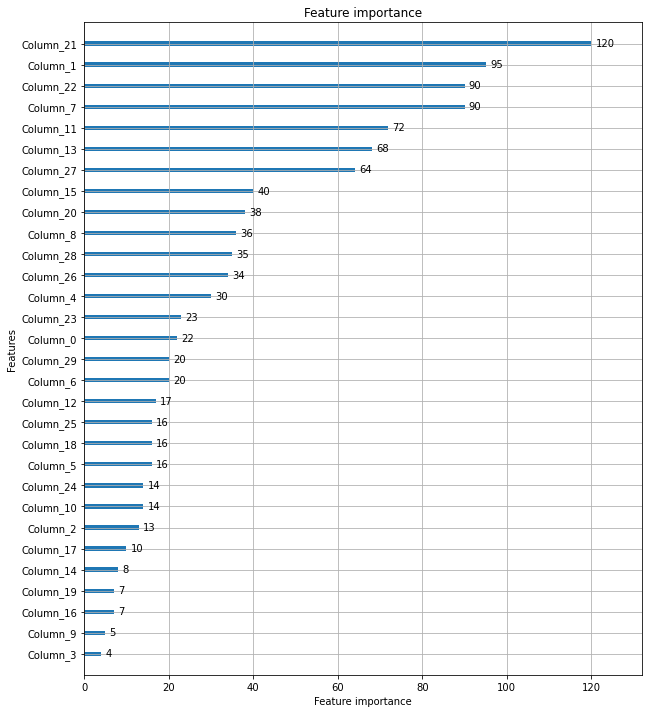

In [10]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

In [20]:
dataset = load_breast_cancer()
X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=156)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}


{'max_depth': <hyperopt.pyll.base.Apply at 0x239bba3f370>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x239bba3fbe0>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x239b874ea00>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x239b8c64cd0>}

In [17]:
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']), min_child_weight=int(search_space['min_child_weight']), learning_rate=search_space['learning_rate'], colsample_bytree=search_space['colsample_bytree'], eval_metric='logloss')
    acc = cross_val_score(xgb_clf, X_train, Y_train, scoring='accuracy', cv=3)    
    return {'loss': -1*np.mean(acc), 'status': STATUS_OK}

In [19]:
trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.default_rng(seed=9))
print(best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\test\.conda\envs\HRD\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

c:\Users\test\.conda\envs\HRD\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

c:\Users\test\.conda\envs\HRD\lib\site-packages\xgboost\sklearn.py:1224: UserWar

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: 'NoneType' object is not iterable